<a href="https://colab.research.google.com/github/TEJASCHAVAN22/Dry-Soil-Detection/blob/main/NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import pandas as pd

# Authenticate and initialize
ee.Authenticate()
ee.Initialize(project="gee-trial2")

# Create interactive map
Map = geemap.Map()

In [2]:
# Load AOI shapefile from Earth Engine assets
aoi = ee.FeatureCollection("projects/gee-trial2/assets/Shapfile/ShapfileShapfile_Chandrapur")
Map.centerObject(aoi, 9)



In [3]:
# Define time range
start_date = '2023-01-01'
end_date = '2023-12-31'

# Load Sentinel-2 SR data
s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
                            .filterBounds(aoi) \
                            .filterDate(start_date, end_date) \
                            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                            .map(lambda img: img.normalizedDifference(['B8', 'B4'])
                            .rename('NDVI').copyProperties(img, ['system:time_start']))

# Function to reduce NDVI over AOI
def reduce_region(img):
    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.geometry(),
        scale=30,
        maxPixels=1e13
    )
    return ee.Feature(None, {
        'NDVI': stats.get('NDVI'),
        'date': ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    })

# Apply function to image collection
ndvi_features = s2.map(reduce_region)


In [4]:
# Apply function to image collection
ndvi_features = s2.map(reduce_region)

# Convert FeatureCollection to pandas DataFrame
ndvi_dict = ndvi_features.aggregate_array('NDVI').getInfo()
date_list = ndvi_features.aggregate_array('date').getInfo()

ndvi_df = pd.DataFrame({
    'Date': pd.to_datetime(date_list),
    'NDVI': ndvi_dict
})

# Sort and drop NA values
ndvi_df = ndvi_df.dropna().sort_values('Date')


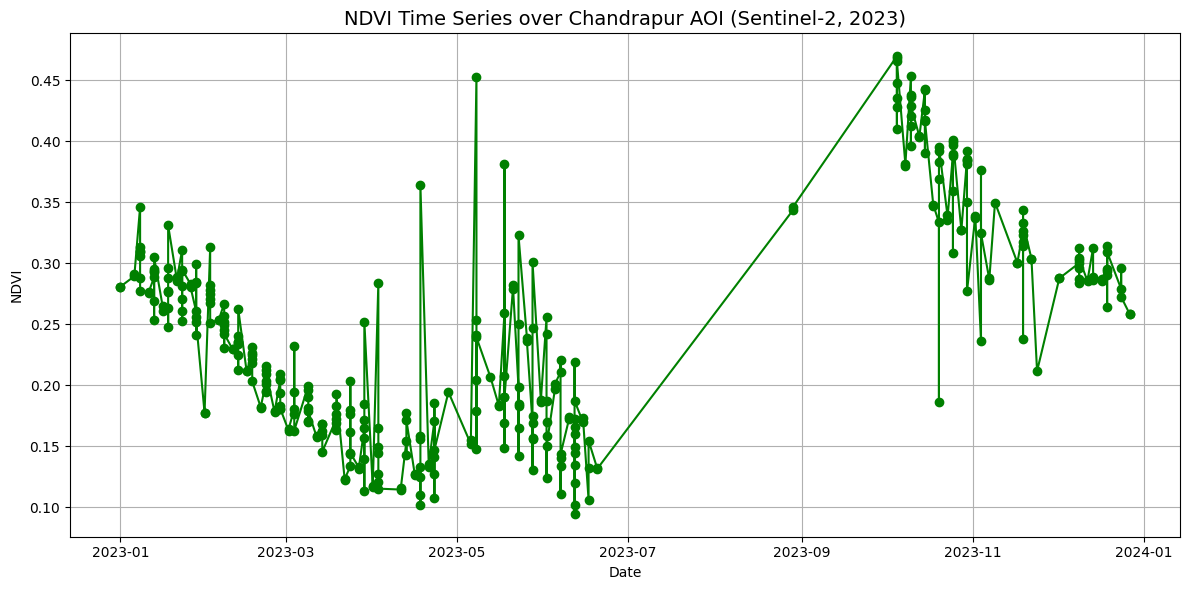

In [5]:
# Plot NDVI time series
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(ndvi_df['Date'], ndvi_df['NDVI'], marker='o', color='green')
plt.title('NDVI Time Series over Chandrapur AOI (Sentinel-2, 2023)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.grid(True)
plt.tight_layout()
plt.show()
